In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from multicopy_STR_genotyping import file_io, str_utils

sns.set_context("poster")
%matplotlib inline

In [3]:
df_segdup_repeats = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", 
                sep="\t", header=None, names=["chr", "start", "end", "period", "unit"])
    .assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])]))
df_pedigree = pd.read_csv("../../data/1000Genomes/1000_genomes_triad_pedigrees_subsamp.csv").drop("Unnamed: 0", axis=1).set_index("sampleID")

df_pedigree.head()

,triadID,role,pgx_id,sex,ENA_FILE_PATH,population
sampleID,,,,,,
HG00421,3,father,onekgbs-HG00421,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00422,3,mother,onekgbs-HG00422,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00423,3,child,onekgbs-HG00423,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR398/ERR398...,CHS
HG00542,21,father,onekgbs-HG00542,M,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS
HG00543,21,mother,onekgbs-HG00543,F,ftp://ftp.sra.ebi.ac.uk/vol1/run/ERR324/ERR324...,CHS


In [4]:
bcf_files = !find ../../data/1000Genomes/variants -name "fam_trio_[0-9]*.bcf"
bcf_files

['../../data/1000Genomes/variants/595/fam_trio_595.bcf',
 '../../data/1000Genomes/variants/169/fam_trio_169.bcf',
 '../../data/1000Genomes/variants/447/fam_trio_447.bcf',
 '../../data/1000Genomes/variants/260/fam_trio_260.bcf',
 '../../data/1000Genomes/variants/409/fam_trio_409.bcf',
 '../../data/1000Genomes/variants/143/fam_trio_143.bcf',
 '../../data/1000Genomes/variants/55/fam_trio_55.bcf',
 '../../data/1000Genomes/variants/320/fam_trio_320.bcf',
 '../../data/1000Genomes/variants/3/fam_trio_3.bcf',
 '../../data/1000Genomes/variants/76/fam_trio_76.bcf']

In [5]:
df_repeats, df_samples = [], []
for bcf in bcf_files:
    df_repeats_inner, df_samples_inner = file_io.dfs_from_vcf(bcf)

    trio_id = None
    family = dict()
    for sample in df_samples_inner["sample"].unique():
        if not trio_id:
            trio_id = df_pedigree.loc[sample, "triadID"]
        family[sample] = df_pedigree.loc[sample, "role"]
    if not len(family) == 3:
        raise ValueError(f"Family relationships could not be properly identified: {family}")

    df_samples_inner = df_samples_inner.assign(
        family_id = trio_id,
        role = lambda x: [family[i] for i in x["sample"]])
     
    df_repeats.append(df_repeats_inner)
    df_samples.append(df_samples_inner)

df_repeats = pd.concat(df_repeats).drop_duplicates()
df_samples = pd.concat(df_samples)
df_repeats.shape, df_samples.shape

((33734, 7), (368535, 7))

In [6]:
df_samples.loc[df_samples["copy_number"] == 0] = (df_samples
                                                  .loc[df_samples["copy_number"] == 0]
                                                  .assign(genotype = lambda x: [[] for i in x["genotype"]]))
df_samples.loc[(df_samples["copy_number"] == 0) & df_samples["frequencies"].isna()] = (
                                                  df_samples
                                                  .loc[(df_samples["copy_number"] == 0) & df_samples["frequencies"].isna()]
                                                  .assign(frequencies = lambda x: [dict() for i in x["frequencies"]]))
df_samples.loc[df_samples["copy_number"] == 0].head()

,sample,str_id,copy_number,frequencies,genotype,family_id,role
2,NA19919,chr1_4065397,0,{},[],595,child
5,NA19919,chr1_4067034,0,{2: 29},[],595,child
8,NA19919,chr1_4067354,0,{},[],595,child
384,NA19908,chr1_67542273,0,"{17: 1, 18: 15}",[],595,father
386,NA19919,chr1_67542273,0,"{17: 7, 18: 11}",[],595,child


In [7]:
def filter_trio_calls(df_samples: pd.DataFrame, segdup_loci: np.array) -> pd.DataFrame:
    # first we drop observations without any reads mapped
    # or where genotype could not be estimated
    df_filt = df_samples.dropna(axis=0, how="any")
    
    # then, drop loci that are located in segmental duplications
    df_filt = df_filt.loc[~df_filt["str_id"].isin(segdup_loci)]
    
    # finally, drop loci that were not observed in all three samples
    observed_in_all = df_filt["str_id"].value_counts().where(lambda x: x == 3).dropna().index
    df_filt = df_filt.loc[df_filt["str_id"].isin(observed_in_all)].reset_index(drop=True)
    
    return df_filt
    

In [8]:
df_samples_filt = []

print(df_samples.shape)
for name, data in df_samples.groupby("family_id"):
    df_samples_filt_inner = filter_trio_calls(data, df_segdup_repeats["str_id"])
    df_samples_filt.append(df_samples_filt_inner)

df_samples_filt = pd.concat(df_samples_filt)

print(df_samples_filt.shape)

df_samples_filt = df_samples_filt.assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_per_cn = lambda x: x["depth"] / x["copy_number"])

# For CN == 0, set depth_per_cn to depth. Not strictly correct but avoids NaNs and infs
df_samples_filt.loc[df_samples_filt["copy_number"] == 0, "depth_per_cn"] = (
    df_samples_filt
    .loc[df_samples_filt["copy_number"] == 0]["depth"])
df_samples_filt.head(12)

(368535, 7)
(121461, 7)


,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn
0,HG00421,chr1_1366512,1,{2: 45},[2],3,father,45,45.0
1,HG00422,chr1_1366512,1,{2: 32},[2],3,mother,32,32.0
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0
3,HG00421,chr1_4067034,2,{2: 25},"[2, 2]",3,father,25,12.5
4,HG00422,chr1_4067034,1,{2: 25},[2],3,mother,25,25.0
5,HG00423,chr1_4067034,2,{2: 26},"[2, 2]",3,child,26,13.0
6,HG00421,chr1_4067354,2,"{2: 36, 3: 1}","[2, 2]",3,father,37,18.5
7,HG00422,chr1_4067354,1,{2: 18},[2],3,mother,18,18.0
8,HG00423,chr1_4067354,2,{2: 32},"[2, 2]",3,child,32,16.0
9,HG00421,chr1_9537182,0,{15: 1},[],3,father,1,1.0


In [9]:
df_samples_filt["child_gt_possible"] = False

for family, fam_data in df_samples_filt.groupby("family_id"):
    possible_child_gts = []
    for locus, locus_data in fam_data.groupby("str_id"):
        locus_data = locus_data.set_index("role")
        
        child = np.array(locus_data.loc["child", "genotype"])
        p1 = np.array(locus_data.loc["father", "genotype"])
        p2 = np.array(locus_data.loc["mother", "genotype"])

        if str_utils.child_gt_possible(child, p1, p2):
            possible_child_gts.append(locus)

    df_samples_filt.loc[df_samples_filt["family_id"] == family] = df_samples_filt.loc[df_samples_filt["family_id"] == family].assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )
    fam_data = fam_data.assign(child_gt_possible = lambda x: [id in possible_child_gts for id in x["str_id"]] )
    
    total_loci = fam_data["str_id"].nunique()
    consistent_loci = fam_data.loc[fam_data["child_gt_possible"]]["str_id"].nunique()
    
    print(f"Family {family}:")
    print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
    print()

total_loci = df_samples_filt[["family_id", "str_id", "child_gt_possible"]].drop_duplicates().shape[0]
consistent_loci = df_samples_filt[["family_id", "str_id", "child_gt_possible"]].drop_duplicates().query("child_gt_possible").shape[0]

print(f"Overall:")
print(f"{consistent_loci} out of {total_loci} loci ({consistent_loci / total_loci * 100:.2f}%) in the child could have possibly been inherited from the parents")
print()

df_samples_filt.head(30)

Family 3:
3385 out of 3728 loci (90.80%) in the child could have possibly been inherited from the parents

Family 55:
3751 out of 4063 loci (92.32%) in the child could have possibly been inherited from the parents

Family 76:
3211 out of 3731 loci (86.06%) in the child could have possibly been inherited from the parents

Family 143:
3182 out of 3622 loci (87.85%) in the child could have possibly been inherited from the parents

Family 169:
3279 out of 3771 loci (86.95%) in the child could have possibly been inherited from the parents

Family 260:
3580 out of 4083 loci (87.68%) in the child could have possibly been inherited from the parents

Family 320:
4082 out of 4606 loci (88.62%) in the child could have possibly been inherited from the parents

Family 409:
3479 out of 4024 loci (86.46%) in the child could have possibly been inherited from the parents

Family 447:
4009 out of 4510 loci (88.89%) in the child could have possibly been inherited from the parents

Family 595:
3919 out of

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible
0,HG00421,chr1_1366512,1,{2: 45},[2],3,father,45,45.0,True
1,HG00422,chr1_1366512,1,{2: 32},[2],3,mother,32,32.0,True
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0,True
3,HG00421,chr1_4067034,2,{2: 25},"[2, 2]",3,father,25,12.5,True
4,HG00422,chr1_4067034,1,{2: 25},[2],3,mother,25,25.0,True
5,HG00423,chr1_4067034,2,{2: 26},"[2, 2]",3,child,26,13.0,True
6,HG00421,chr1_4067354,2,"{2: 36, 3: 1}","[2, 2]",3,father,37,18.5,True
7,HG00422,chr1_4067354,1,{2: 18},[2],3,mother,18,18.0,True
8,HG00423,chr1_4067354,2,{2: 32},"[2, 2]",3,child,32,16.0,True
9,HG00421,chr1_9537182,0,{15: 1},[],3,father,1,1.0,False


In [21]:
df_repeats[["str_id", "unit", "period", "ref"]]

,str_id,unit,period,ref
0,chr1_4065397,CACTCA,6,2
1,chr1_4067034,CACTCA,6,2
2,chr1_4067354,CACTCA,6,2
3,chr1_10188308,TA,2,6
4,chr1_10188568,T,1,19
...,...,...,...,...
11448,chrY_11099949,T,1,10
11449,chrY_11100134,G,1,12
11450,chrY_11100369,T,1,12
11451,chrY_11100960,T,1,16


In [22]:
df_samples_filt = (df_samples_filt
                   .assign(distinct_alleles = lambda x: [len(set(i)) for i in x["genotype"]],)
                   .merge(df_repeats[["str_id", "unit", "period", "ref"]], on="str_id"))
df_samples_filt

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,distinct_alleles,unit,period,ref
0,HG00421,chr1_1366512,1,{2: 45},[2],3,father,45,45.0,True,1,GTGA,4,3
1,HG00422,chr1_1366512,1,{2: 32},[2],3,mother,32,32.0,True,1,GTGA,4,3
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0,True,1,GTGA,4,3
3,HG01124,chr1_1366512,2,"{2: 17, 3: 14}","[2, 3]",76,father,31,15.5,True,2,GTGA,4,3
4,HG01125,chr1_1366512,1,{2: 29},[2],76,mother,29,29.0,True,1,GTGA,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121456,NA19909,chrX_135642566,2,{3: 25},"[3, 3]",595,mother,25,12.5,False,1,GCAT,4,3
121457,NA19919,chrX_135642566,1,{3: 12},[3],595,child,12,12.0,False,1,GCAT,4,3
121458,NA19908,chrY_10654069,2,{2: 42},"[2, 2]",595,father,42,21.0,True,1,TCTAT,5,2
121459,NA19909,chrY_10654069,0,{2: 36},[],595,mother,36,36.0,True,0,TCTAT,5,2


In [143]:
def plot_fam_trio(df, fam, locus):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    df_plot = df.query(f"family_id == {fam} and str_id == '{locus}'").set_index("role")
    allele_lengths = np.concatenate([list(i.keys()) for i in df_plot["frequencies"]])
    
    x_order = pd.Categorical(np.arange(allele_lengths.min(), allele_lengths.max() + 1), ordered=True)
    
    for i, (role, ax) in enumerate(zip(["father", "mother", "child"], axes.ravel())):
    
        frequencies = df_plot.loc[role, "frequencies"]
        if not frequencies:
            print(f"No reads mapped to locus for {role}")
            continue
        df_freqs = pd.DataFrame.from_dict(frequencies, orient="index", columns=["count"]).reset_index(names="allele length")
        
        ax = sns.barplot(
            data=df_freqs,
            x = "allele length",
            y = "count",
            order = x_order,
            ax = ax,
            color = sns.color_palette("colorblind")[i]
        )
        cn = df_plot.loc[role, "copy_number"]
        gt = df_plot.loc[role, "genotype"]
        ax.set(
            title = f"{role} (genotype {gt})",
            xlabel = "Repeat length (# units)",
            ylabel = "Count"
        )
    
    plt.tight_layout()

    return axes

In [25]:
(df_samples_filt
 .query("child_gt_possible and copy_number == 3 and period > 1 and role == 'child' and distinct_alleles == 3")
 .head(54))

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,distinct_alleles,unit,period,ref
7250,HG00423,chr10_34185812,3,"{8: 11, 9: 11, 10: 11}","[8, 9, 10]",3,child,33,11.000000,True,3,TATAT,5,9
20960,HG00423,chr16_21576519,3,"{7: 5, 9: 1, 10: 4, 12: 8}","[7, 10, 12]",3,child,18,6.000000,True,3,AAAT,4,10
21230,HG00423,chr16_22617048,3,"{18: 15, 20: 13, 22: 14}","[18, 20, 22]",3,child,42,14.000000,True,3,AC,2,20
21470,HG00423,chr16_22622486,3,"{20: 10, 21: 1, 24: 11, 25: 11}","[20, 24, 25]",3,child,33,11.000000,True,3,TG,2,22
23585,HG01126,chr16_28603093,3,"{12: 8, 13: 9, 15: 8}","[12, 13, 15]",76,child,25,8.333333,True,3,TTA,3,16
23594,HG02612,chr16_28603093,3,"{14: 9, 15: 9, 16: 8}","[14, 15, 16]",260,child,26,8.666667,True,3,TTA,3,16
46553,HG00423,chr6_309680,3,"{14: 7, 19: 9, 20: 6}","[14, 19, 20]",3,child,22,7.333333,True,3,AC,2,19
47033,HG00423,chr6_346430,3,"{14: 13, 15: 10, 18: 16}","[14, 15, 18]",3,child,39,13.000000,True,3,AC,2,14
47039,HG01126,chr6_346430,3,"{14: 13, 16: 20, 18: 12}","[14, 16, 18]",76,child,45,15.000000,True,3,AC,2,14
51515,HG01126,chr7_100964285,3,"{7: 19, 8: 9, 9: 8}","[7, 8, 9]",76,child,36,12.000000,True,3,TAA,3,7


In [96]:
fam = 3
locus = "chr10_34185812"
df_samples_filt.query(f"family_id == {fam} and str_id == '{locus}'")

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,distinct_alleles,unit,period,ref
7248,HG00421,chr10_34185812,3,"{9: 8, 10: 14}","[9, 10, 10]",3,father,22,7.333333,True,2,TATAT,5,9
7249,HG00422,chr10_34185812,2,"{8: 9, 11: 5}","[8, 11]",3,mother,14,7.000000,True,2,TATAT,5,9
7250,HG00423,chr10_34185812,3,"{8: 11, 9: 11, 10: 11}","[8, 9, 10]",3,child,33,11.000000,True,3,TATAT,5,9


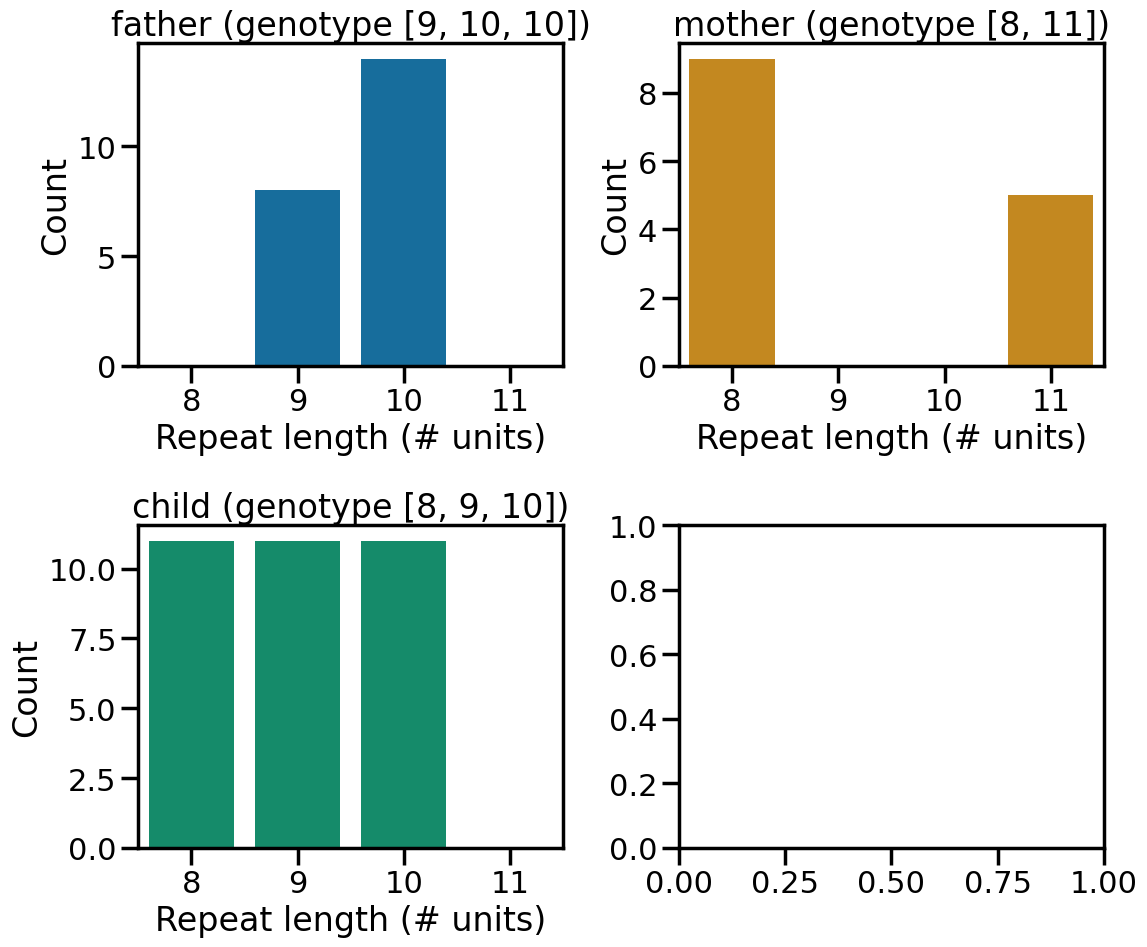

In [112]:
axes = plot_fam_trio(df_samples_filt, 3, "chr10_34185812")

In [26]:
fam = 76
locus = "chr6_35794661"
df_samples_filt.query(f"family_id == {fam} and str_id == '{locus}'")

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,distinct_alleles,unit,period,ref
72876,HG01124,chr6_35794661,3,"{11: 11, 13: 11, 16: 1, 17: 1, 18: 14}","[11, 13, 18]",76,father,38,12.666667,True,3,GT,2,17
72877,HG01125,chr6_35794661,2,"{17: 22, 18: 1}","[17, 17]",76,mother,23,11.500000,True,1,GT,2,17
72878,HG01126,chr6_35794661,3,"{11: 16, 17: 12, 18: 10}","[11, 17, 18]",76,child,38,12.666667,True,3,GT,2,17


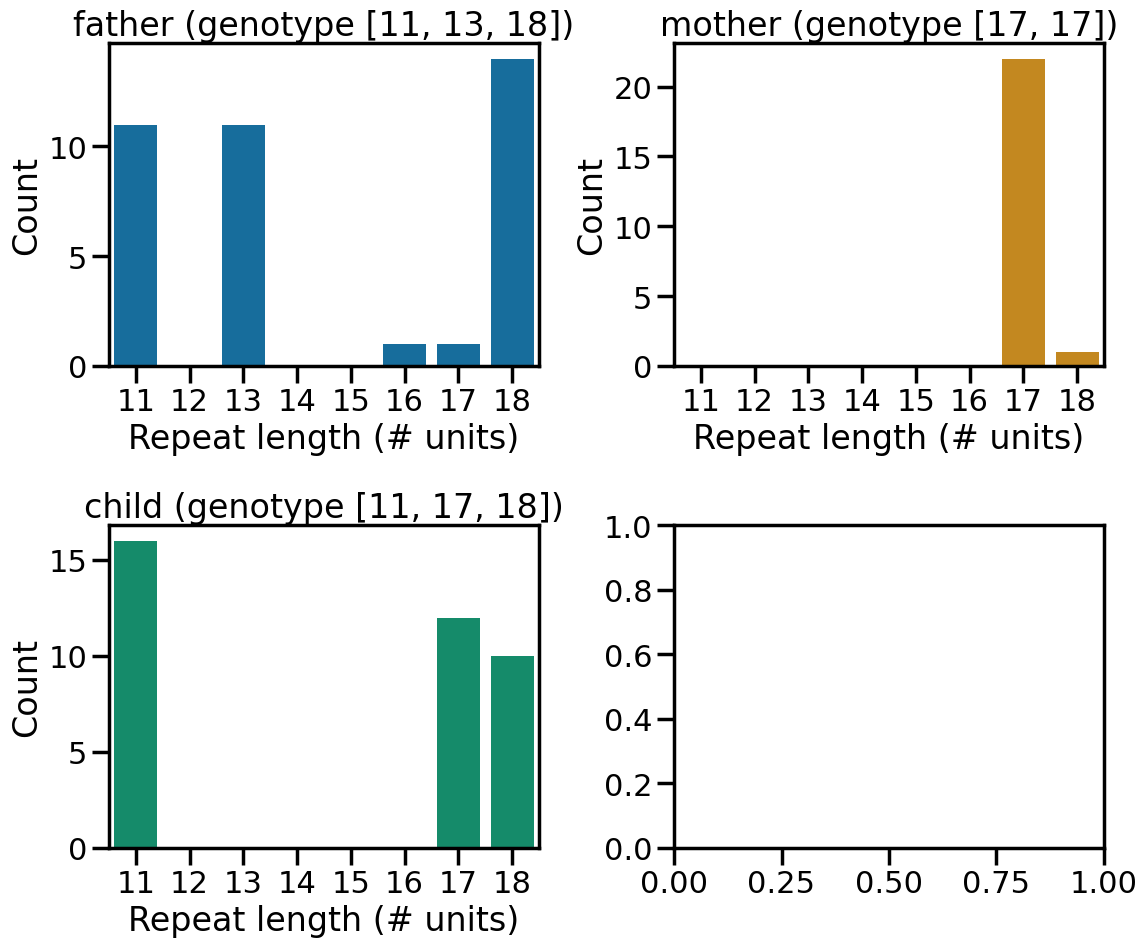

In [113]:
axes = plot_fam_trio(df_samples_filt, 76, "chr6_35794661")

In [139]:
(df_samples_filt
 .query("child_gt_possible and copy_number < 2 and period > 2 and role == 'child'")
 .head(54))

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,distinct_alleles,unit,period,ref
2,HG00423,chr1_1366512,1,{2: 24},[2],3,child,24,24.0,True,1,GTGA,4,3
5,HG01126,chr1_1366512,1,{2: 34},[2],76,child,34,34.0,True,1,GTGA,4,3
14,HG01126,chr1_4067034,1,{2: 32},[2],76,child,32,32.0,True,1,CACTCA,6,2
18,HG01884,chr1_4067034,1,{2: 24},[2],169,child,24,24.0,True,1,CACTCA,6,2
27,NA07014,chr1_4067034,1,{2: 28},[2],447,child,28,28.0,True,1,CACTCA,6,2
32,NA19919,chr1_4067034,0,{2: 29},[],595,child,29,29.0,True,0,CACTCA,6,2
41,HG01126,chr1_4067354,1,{2: 16},[2],76,child,16,16.0,True,1,CACTCA,6,2
45,HG01884,chr1_4067354,1,{2: 14},[2],169,child,14,14.0,True,1,CACTCA,6,2
54,NA07014,chr1_4067354,1,{2: 18},[2],447,child,18,18.0,True,1,CACTCA,6,2
59,NA19919,chr1_4067354,0,{},[],595,child,0,0.0,True,0,CACTCA,6,2


In [150]:
fam = 409
locus = "chr1_9787208"
df_samples_filt.query(f"family_id == {fam} and str_id == '{locus}'")

,sample,str_id,copy_number,frequencies,genotype,family_id,role,depth,depth_per_cn,child_gt_possible,distinct_alleles,unit,period,ref
84,HG03793,chr1_9787208,1,{3: 12},[3],409,mother,12,12.0,True,1,TCCA,4,3
85,HG03794,chr1_9787208,1,{3: 9},[3],409,father,9,9.0,True,1,TCCA,4,3
86,HG03795,chr1_9787208,1,{3: 11},[3],409,child,11,11.0,True,1,TCCA,4,3


[2]
Categories (1, int64): [2]
[2]
Categories (1, int64): [2]
[2]
Categories (1, int64): [2]


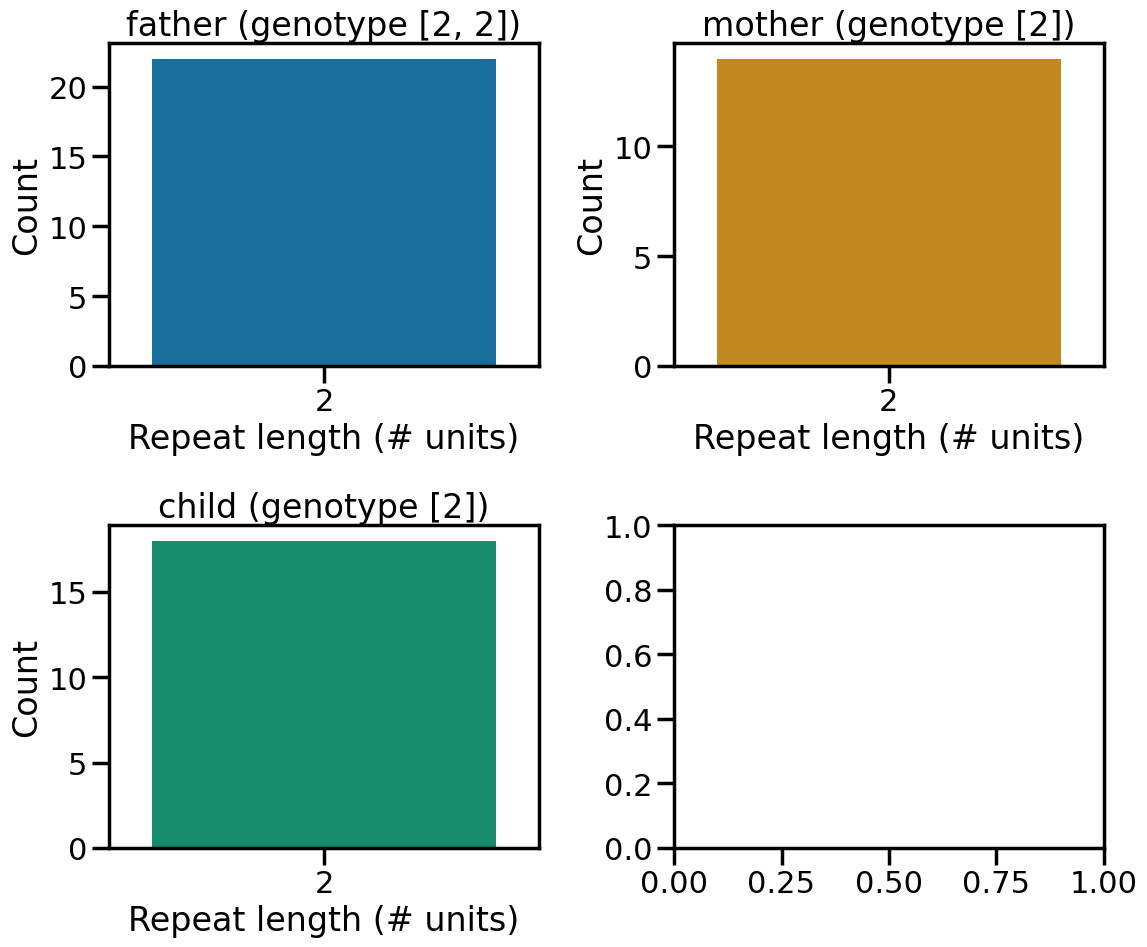

In [141]:
axes = plot_fam_trio(df_samples_filt, fam, locus)